In [1]:
import torch
import torchvision
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from collections import defaultdict
from datetime import datetime
from pathlib import Path
from IPython.display import clear_output

from torchvision.datasets import MNIST
from torch.utils.data import Dataset

from misc.utils import *
from misc.datasets_ae import *
from misc.autoencoder import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

path = Path("./").resolve()
experiments_path = path / "MNIST/"
models_path = experiments_path / "models/"
results_path = experiments_path / "results/"

# seeding
SEED = 12
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

# for seeding dataloaders in .py
# g = torch.Generator()
# g.manual_seed(SEED)
# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     numpy.random.seed(worker_seed)
#     random.seed(worker_seed)

Device: cuda
Devices count: 1


### Global settings

In [2]:
""" 
Training parameters
"""
# Autoencoder
X_latent_dim = 10             # Input dimension after compression.
X_autoencoder_n_epochs = 500  # Number of epochs to train the autoencoder.
X_autoencoder = Autoencoder(
    MNIST_ConvEncoder(latent_dim=X_latent_dim), 
    MNIST_ConvDecoder(latent_dim=X_latent_dim) ).to(device)

# Data
autoencoder_batch_size_train = 512
autoencoder_batch_size_test  = 1024

# Training
autoencoder_loss = torch.nn.L1Loss()
lr = 1e-3
autoencoder_opt = torch.optim.Adam(X_autoencoder.parameters(), lr=lr)    

# Samplewise Metrics
loss_samplewise = torch.nn.L1Loss(reduction='none')

## Dataset

In [3]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = MNIST(root="./.cache", download=True, transform=image_transform)
test_dataset = MNIST(root="./.cache", download=True, transform=image_transform, train=False)

In [5]:
# images_sub = np.array([train_dataset[i][0][0].numpy() for i in range(-6000, 0, 1)])
# images_aug = images_sub[:len(images_sub)//2] + images_sub[len(images_sub)//2:]

# images_base = np.array([train_dataset[i][0][0].numpy() for i in range(len(train_dataset)-6000)])

# # plt.hist(np.mean(images_base, axis=(1,2)),bins = 100);

# plt.hist(np.mean(images_aug, axis=(1,2)),bins = 100);
# plt.hist(np.mean(images_sub[:len(images_sub)//2], axis=(1,2)),bins = 100);

# plt.show()

In [6]:
aug_ratio = 0.1
train_dataset_sums = MNIST_w_imagesums(train_dataset, aug_ratio=aug_ratio)

dataloader1 = torch.utils.data.DataLoader(
    train_dataset_sums, 
    batch_size=1, 
    shuffle=False)


mu_base, var_base = [], []
mu_aug, var_aug = [], []
    
for i, val in tqdm(enumerate(dataloader1)):
    if (i > (1-aug_ratio)*len(train_dataset)):
        mu_aug.append(val[0][0][0].numpy().mean())
        var_aug.append(val[0][0][0].numpy().std())
    else:
        mu_base.append(val[0][0][0].numpy().mean())
        var_base.append(val[0][0][0].numpy().std())
        
print("base imgs stats",  np.mean(mu_base), np.mean(var_base))
print("aug imgs stats",  np.mean(mu_aug), np.mean(var_aug))

57000it [00:11, 5077.19it/s]

base imgs stats -9.465788e-06 0.9780797
aug imgs stats -0.0015031756 0.9998649


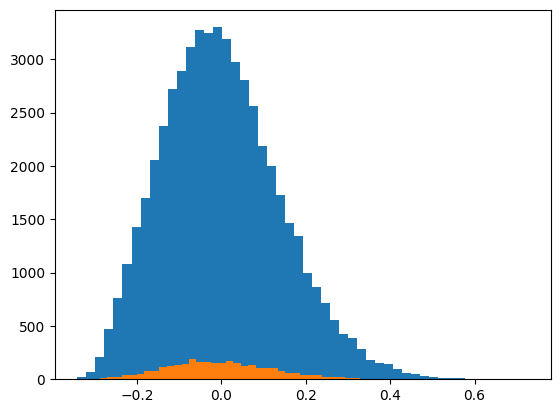

In [7]:
plt.hist(mu_base,bins=50)
plt.hist(mu_aug,bins=50)
plt.show()

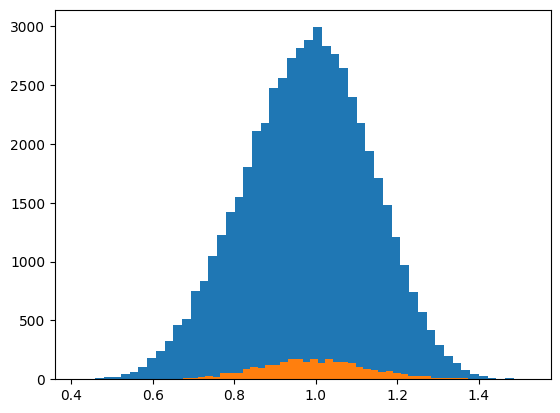

In [8]:
plt.hist(var_base,bins=50)
plt.hist(var_aug,bins=50)
plt.show()

In [9]:
# train_dataset_sums = MNIST_w_imagesums(train_dataset, aug_ratio=0.1)

# dataloader1 = torch.utils.data.DataLoader(
#     train_dataset_sums, 
#     batch_size=1, 
#     shuffle=False)

# for i, val in (enumerate(dataloader1)):
#     if (i > 54000 and i<54003) or (i > 0 and i<3) :
#         print(i, val[1])
#         plt.imshow(val[0][0][0].numpy())
#         plt.show()


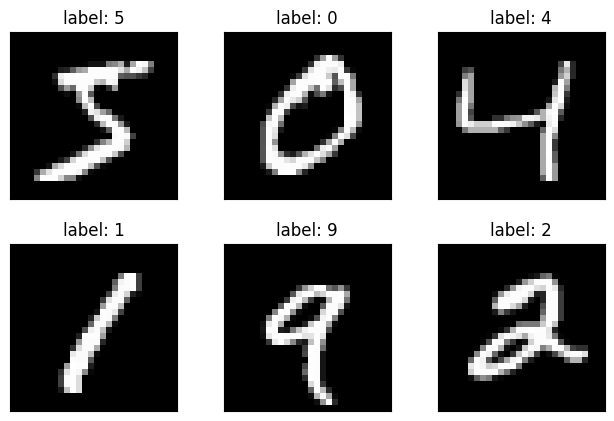

In [10]:
# Visualisation
show_images(*split_lists([(train_dataset[index][0], f"label: {train_dataset[index][1]}") for index in range(6)]))

In [11]:
train_dataset_autoencoder = AutoencoderDataset(train_dataset_sums)

test_dataset_autoencoder = AutoencoderDataset(test_dataset)

train_dataloader_autoencoder = torch.utils.data.DataLoader(
    train_dataset_autoencoder, 
    batch_size=autoencoder_batch_size_train, 
    shuffle=True,
    pin_memory=True,
    num_workers=0,
    # reproducibility for .py
    # worker_init_fn=seed_worker,
    # generator=g,
)
test_dataloader_autoencoder  = torch.utils.data.DataLoader(
    test_dataset_autoencoder, 
    batch_size=autoencoder_batch_size_test, 
    shuffle=False,
    pin_memory=True,
    num_workers=4,
)
# for statistics on train data
train_dataloader_autoencoder_nonshuffle = torch.utils.data.DataLoader(
    train_dataset_autoencoder, 
    batch_size=autoencoder_batch_size_train, 
    shuffle=False,
    pin_memory=True,
    num_workers=0,
    # reproducibility for .py
    # worker_init_fn=seed_worker,
    # generator=g,
)

In [12]:
def autoencoder_callback(autoencoder, autoencoder_metrics=None):
    clear_output(True)
    
    was_in_training = autoencoder.training
    autoencoder.eval()
    
    # Display some images..
    with torch.no_grad():
        samples = [sample[0] for sample in random.choices(test_dataset_autoencoder, k=3)]
        samples += [autoencoder(sample[None,:].to(device)).cpu().detach()[0] for sample in samples]
        show_images(samples)
        
    # Display loss/metrics plots.
    if not (autoencoder_metrics is None):
        plt.figure(figsize=(12,4))
        for index, (name, history) in enumerate(sorted(autoencoder_metrics.items())):
            plt.subplot(1, len(autoencoder_metrics), index + 1)
            plt.title(name)
            plt.plot(range(1, len(history) + 1), history)
            plt.grid()

        plt.show();
        
    autoencoder.train(was_in_training)

In [13]:
X_autoencoder_path = models_path / "autoencoders/"
encoder_path = X_autoencoder_path / f"X_encoder_{X_latent_dim}_{X_autoencoder_n_epochs}_wimgsums.pt"
decoder_path = X_autoencoder_path / f"X_decoder_{X_latent_dim}_{X_autoencoder_n_epochs}_wimgsums.pt"

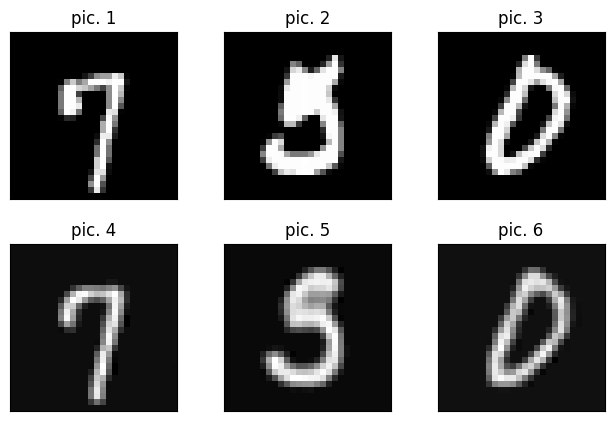

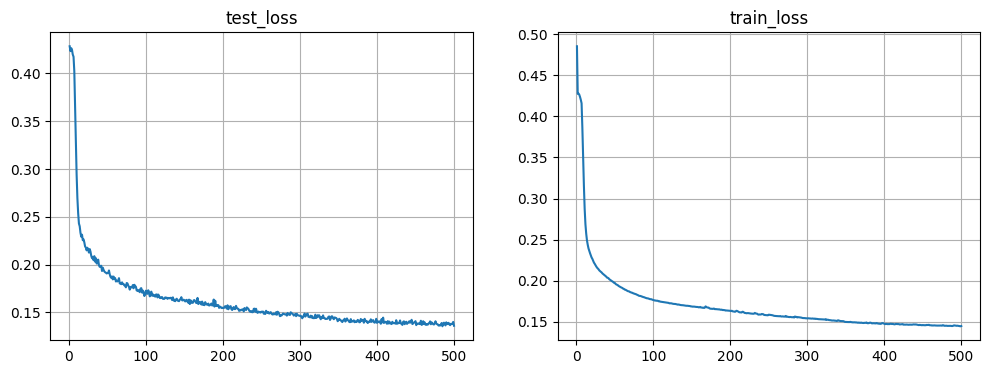

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [2:20:42<00:00, 16.88s/it]


In [14]:
load_X_autoencoder = False

if load_X_autoencoder:
    try:
        X_autoencoder.encoder.load_state_dict(torch.load(encoder_path))
        X_autoencoder.decoder.load_state_dict(torch.load(decoder_path))
        autoencoder_callback(X_autoencoder)
    except:
        print("The autoencoder is not found or cannot be loaded.")
        load_X_autoencoder = False

if not load_X_autoencoder:
    results = train_autoencoder(
        X_autoencoder, 
        train_dataloader_autoencoder, 
        test_dataloader_autoencoder, 
        autoencoder_loss=autoencoder_loss,
        autoencoder_opt=autoencoder_opt, 
        n_epochs=X_autoencoder_n_epochs, 
        callback=autoencoder_callback,
        device=device,
        # samplewise stats
        train_dataloader_nonshuffle=train_dataloader_autoencoder_nonshuffle,
#         loss_samplewise=loss_samplewise,
    )
    
    os.makedirs(X_autoencoder_path, exist_ok=True)
    torch.save(X_autoencoder.encoder.state_dict(), encoder_path)
    torch.save(X_autoencoder.decoder.state_dict(), decoder_path)

In [15]:
bn_logits = np.array(results['bn_logits'])

In [16]:
bn_logits.nbytes / 1024 / 1024 # Mbytes

1087.188720703125

In [17]:
bn_logits.shape

(500, 57000, 10)

In [18]:
os.makedirs(results_path, exist_ok=True)
bn_logits_path = results_path / f"bn_logits_{X_latent_dim}_{X_autoencoder_n_epochs}"

np.save(
    bn_logits_path,
    bn_logits,
)

In [19]:
# X_compressed = get_outputs(X_autoencoder.encoder, test_dataloader_autoencoder, device).numpy()